# Data Exploration

This notebook analyzes intake and outcome data from the Austin Animal Center to understand factors associated with cat adoption and length of stay. The analysis focuses on intake characteristics, operational patterns, and data quality considerations to inform downstream SQL analysis, predictive modeling, and A/B testing. To avoid outcome leakage, all insights for modeling are strictly derived from information available upon intake.

Notes: 
- Some variables in this notebook are for descriptive analysis only. If a variable is informative, it will be formalized in `features.py`.
- For readability, plotting code cells are hidden. All data transformations and aggregations are shown.

## Summary of Key Findings

- Missing outcomes: ~1% of intakes (primarily recent) do not yet have outcomes and should be excluded from adoption-rate denominators.
- Adoption rate: Kittens are adopted faster and at higher rates. Intake type and having a name at intake also correlate with adoption likelihood.
- Length of stay (LOS): ~75% of stays are under one month. Kittens and young adults tend to have shorter stays, with LOS varying by intake type.
- Seasonality: Intakes and LOS are seasonal, surging in spring and summer. Adoption rates also vary throughout the year.
  
These findings inform feature selection for downstream SQL analysis, predictive modeling, and A/B testing.

## Data Overview

The processed dataset contains approximately 69,300 cat intake records from the Austin Animal Center, ranging from October 2013 to May 2025. Each row represents a single intake, not a unique cat; cats may be taken in more than once if they return to the center.

Each intake is matched to the earliest subsequent outcome when available using Animal ID and event timestamps. As a result, most intakes have a corresponding outcome and a length of stay (time elapsed between intake and outcome). Only a small fraction (~1%) do not yet have recorded outcomes.

Key variables used throughout this analysis include:

- Intake timing: date and time, month and year
- Intake characteristics: intake type, sex upon intake, age upon intake, age group upon intake, name presence
- Outcome characteristics: outcome presence, adoption flag, outcome type
- Length of stay (LOS): length of stay in days

All analyses are conducted at the intake level.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle

pd.set_option("display.max_columns", None)

## Load Data

In [2]:
DATA_PATH = "../data/processed/aac_processed.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["datetime_intake", 
                                         "month_year_intake", 
                                         "datetime_outcome", 
                                         "month_year_outcome"])

df.head()

,Animal ID,Name_intake,datetime_intake,month_year_intake,Found Location,Intake Type,Intake Condition,Animal Type_intake,Sex upon Intake,Age upon Intake,Breed_intake,Color_intake,age_intake_months,age_group_intake,Date of Birth,Name_outcome,datetime_outcome,month_year_outcome,Outcome Type,Outcome Subtype,Animal Type_outcome,Sex upon Outcome,Age upon Outcome,Breed_outcome,Color_outcome,age_outcome_months,age_group_outcome,is_adopted,has_outcome,length_of_stay_days,invalid_los
0,A664235,NaN,2013-10-01 08:33:00-05:00,2013-10-01,Abia in Austin (TX),Stray,Normal,Cat,NaN,1 week,Domestic Shorthair Mix,Orange/White,0.233333,kitten,2013-09-24,NaN,2013-10-01 10:39:00-05:00,2013-10-01,Transfer,Partner,Cat,NaN,1 week,Domestic Shorthair Mix,Orange/White,0.233333,kitten,False,True,0.0,False
1,A664236,NaN,2013-10-01 08:33:00-05:00,2013-10-01,Abia in Austin (TX),Stray,Normal,Cat,NaN,1 week,Domestic Shorthair Mix,Orange/White,0.233333,kitten,2013-09-24,NaN,2013-10-01 10:44:00-05:00,2013-10-01,Transfer,Partner,Cat,NaN,1 week,Domestic Shorthair Mix,Orange/White,0.233333,kitten,False,True,0.0,False
2,A664237,NaN,2013-10-01 08:33:00-05:00,2013-10-01,Abia in Austin (TX),Stray,Normal,Cat,NaN,1 week,Domestic Shorthair Mix,Orange/White,0.233333,kitten,2013-09-24,NaN,2013-10-01 10:44:00-05:00,2013-10-01,Transfer,Partner,Cat,NaN,1 week,Domestic Shorthair Mix,Orange/White,0.233333,kitten,False,True,0.0,False
3,A664238,NaN,2013-10-01 09:33:00-05:00,2013-10-01,Outside Jurisdiction,Stray,Normal,Cat,NaN,4 months,American Shorthair Mix,Black/White,4.000000,kitten,2013-06-01,NaN,2013-10-01 16:47:54-05:00,2013-10-01,Euthanasia,Medical,Cat,NaN,4 months,American Shorthair Mix,Black/White,4.000000,kitten,False,True,0.0,False
4,A664256,Donnie,2013-10-01 10:59:00-05:00,2013-10-01,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,17 years,Domestic Shorthair Mix,Brown Tabby/White,204.000000,senior,1996-10-01,Donnie,2013-10-10 13:17:00-05:00,2013-10-01,Transfer,Partner,Cat,Neutered Male,17 years,Domestic Shorthair Mix,Brown Tabby/White,204.000000,senior,False,True,9.0,False


## Data Shape and Types

The data set has 69,324 rows and 29 columns.

In [3]:
df.shape

(69324, 31)

The data types of each of the 29 columns are below.

In [4]:
df.dtypes.to_frame("data type").T

,Animal ID,Name_intake,datetime_intake,month_year_intake,Found Location,Intake Type,Intake Condition,Animal Type_intake,Sex upon Intake,Age upon Intake,Breed_intake,Color_intake,age_intake_months,age_group_intake,Date of Birth,Name_outcome,datetime_outcome,month_year_outcome,Outcome Type,Outcome Subtype,Animal Type_outcome,Sex upon Outcome,Age upon Outcome,Breed_outcome,Color_outcome,age_outcome_months,age_group_outcome,is_adopted,has_outcome,length_of_stay_days,invalid_los
data type,object,object,"datetime64[ns, UTC-05:00]",datetime64[ns],object,object,object,object,object,object,object,object,float64,object,object,object,"datetime64[ns, UTC-05:00]",datetime64[ns],object,object,object,object,object,object,object,float64,object,bool,bool,float64,bool


## Data Quality

**Approximately 1% of intake records do not have a recorded outcome**. This 1% figure is a good sign that the join logic in ETL works as intended. These missing outcomes likely represent cats still in shelter at the of the data cutoff on May 5, 2025 or records with unlogged outcomes. We test these hypotheses below in section "Missing Outcomes."

Among intakes with outcomes, the overall adoption rate is 52%, just above average.

There are no outcome before intake and no negative length of stay. This means the join logic in ETL works, and that all length of stay values are valid.

In [5]:
# outcome coverage
print(f"Percentage of intakes having an outcome: {df["has_outcome"].mean():.2%}")

# adoption rate
print(f"\nAdoption rate among outcomes: {df.loc[df["has_outcome"], "is_adopted"].mean():.2%}")

# outcome before intake
print(f"\nCount of outcome before intake: {(df["datetime_outcome"] < df["datetime_intake"]).sum()}")

# negative length of stay check
print(f"\nCount of negative length of stay (LOS): {df["invalid_los"].sum()}")

Percentage of intakes having an outcome: 98.94%

Adoption rate among outcomes: 51.67%

Count of outcome before intake: 0

Count of negative length of stay (LOS): 0


## Missing Outcomes

**Missing outcomes occur most frequently in recent intake months close to the data cuttoff in May 2025**. The outcomes for those intakes had not yet occurred as of data extraction. This behavior is expected in longitudinal shelter data and indicates that the join logic is functioning as intended.

In [6]:
df.groupby("month_year_intake")["Outcome Type"]\
    .apply(lambda x: x.isna().mean())\
    .to_frame("rate_of_missing_outcome")\
    .reset_index()\
    .sort_values(by="month_year_intake", ascending=False)\
    .head(5)

,month_year_intake,rate_of_missing_outcome
139,2025-05-01,0.784615
138,2025-04-01,0.415238
137,2025-03-01,0.185185
136,2025-02-01,0.054545
135,2025-01-01,0.037572


To sanity check, we can look at missing outcomes across age groups upon intake. Missing outcome is distributed equally random across age groups so there is no observed systemically missing outcomes.

In [7]:
df.groupby("age_group_intake")["Outcome Type"]\
    .apply(lambda x: x.isna().mean())\
    .sort_values(ascending=False)\
    .to_frame("rate_of_missing_outcome")\
    .reset_index()

,age_group_intake,rate_of_missing_outcome
0,kitten,0.010891
1,young adult,0.010458
2,senior,0.007502
3,mature adult,0.006022


### Treatment of Missing Outcomes in Analysis

Records without outcomes are handled based on the downstream analysis:

- **EDA and operational analysis (inventory, LOS):
Retained**, as they represent cats still in center at the time of the data cutoff.

- **Adoption modeling:
Excluded**, as the outcome label is unknown and including it would introduce noise.

This approach preserves data completeness for descriptive analysis while ensuring valid supervised modeling.

## Missing Values

Among the 16 columns with missing values, `Outcome Subtype` is the most sparse column with 43% values missing. Note that `Outcome Type` has only 1% missing and `Outcome Subtype` serves to give more details on `Outcome Type`. Although almost every intake has an outcome, only more than half of the intakes are given more clarification on the outcome. We take a closer look at the missing values in `Outcome Subtype` by `Outcome Type` below.

The next two columns, `Name_intake` and `Name_outcome`, have under 40% of values missing, which means that more than half of the cats have their names noted. The next two columns, `Sex upon Intake` and `Sex upon Outcome`, have 7%-8% of values missing, which indicates that the majority of cats have their sex documented. Sex is more apparent than Name so it makes sense that most `Sex upon Intake` and `Sex upon Outcome` are available. We look at the association between Name/Sex and `Intake Type` below.

The last 11 columns are related to outcomes and only have 1% of values missing. This is consistent with the fact that 99% of intakes have an outcome, as shown above. 

In [8]:
missing_values = df.isna().mean().sort_values(ascending=False)
missing_values = missing_values[missing_values>0]
print(f"Number of columns with missing values: {len(missing_values)}.")
missing_values.to_frame("% Missing Values")

Number of columns with missing values: 16.


,% Missing Values
Outcome Subtype,0.422725
Name_outcome,0.394596
Name_intake,0.391322
Sex upon Outcome,0.081025
Sex upon Intake,0.072572
Outcome Type,0.010574
Age upon Outcome,0.010501
age_outcome_months,0.010501
month_year_outcome,0.010444
datetime_outcome,0.010444


### Missing Outcome Subtype by Outcome Type

**The missing values in `Outcome Subtype` are structural and dependent on the nature of `Outcome Type`**:

Note: "Rto-Adopt" means uniting a lost or stray pet with the original owner ("Rto" here stands for return-to-owner). "Rto-Adopt" is different in nature to "Return to Owner" and "Adoption." "Return to Owner" means the former owner surrenders the pet to the center and the center gives it back. "Adoption" means finding a new home for the pet, as opposed to returning it to its original home.

`Outcome Subtype` is not available when the outcome is "Disposal", "Rto-Adopt" or "Relocate", and almost never available when the outcome is "Return to Owner". These types of outcomes are clear enough and supposedly decided by the center through procedures in place, so the center does not clarify those.

Under a third of adoptions have more details. As adoption is considered the most desirable outcome (besides "Rto-Adopt"), it makes business sense for the center to not typically record details on adoptions. 

The large majority of "Missing" cases (86%) have more clarification. Details are almost always available when the outcome is "Died" or "Euthanasia", as those are undesirable outcomes: the cats are not adopted before the end of their lives.

When the outcome is "Transfer", details were always provided. The center probably wants to track where cats are transferred to, which makes sense for the animal shelter system.

In [9]:
df.groupby("Outcome Type")["Outcome Subtype"].apply(lambda x: x.isna().mean()).sort_values(ascending=False).reset_index()

,Outcome Type,Outcome Subtype
0,Disposal,1.000000
1,Rto-Adopt,1.000000
2,Relocate,1.000000
3,Return to Owner,0.988784
4,Adoption,0.713492
5,Missing,0.137255
6,Died,0.027467
7,Euthanasia,0.007129
8,Transfer,0.000000


### Missing Name and Sex by Intake Type

**The missing values in Name and Sex are structural and dependent on `Intake Type`**:

Almost half of the strays are anonymous and 10% of them are of unknown sex. One quarter of abandoned cats are anonymous. This is expected as strays and abandoned cats are often rescued without the presense of an owner. Abandoned cats might have items on them that indicate their names, but that's unlikely for strays.

Name and Sex are usually known through "Public Assist", "Owner Surrender" and "Euthanasia Request" as humans are present to provide that information.

In [10]:
df.groupby("Intake Type")[["Name_intake", 
                           "Name_outcome", 
                           "Sex upon Intake", 
                           "Sex upon Outcome"]]\
    .apply(lambda x: x.isna().mean()).sort_values(by="Name_intake", ascending=False)

,Name_intake,Name_outcome,Sex upon Intake,Sex upon Outcome
Intake Type,,,,
Stray,0.468115,0.471398,0.090422,0.100308
Abandoned,0.247326,0.250000,0.044118,0.045455
Public Assist,0.159890,0.161957,0.038594,0.040662
Owner Surrender,0.119480,0.122900,0.006766,0.010632
Euthanasia Request,0.100000,0.100000,0.050000,0.050000


## Intake-related Data

### Age Upon Intake

The cats taken in are from 0 to 264 months (22 years) old, but their **age tends towards the younger side**. Although the average cat is 15 months old, the median is as young as 2 months old. In fact, at least 75% are kittens (12 months or younger). 

Age at intake varies widely, with the standard deviation being 30 years.

In [11]:
df["age_intake_months"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
age_intake_months,69324.0,15.411641,30.305883,0.0,0.933333,2.0,12.0,264.0


The distribution of age at intake is heavily right skewed. Each bin represents 12 months; as described above, the vast majority are kittens.

(The hidden code cell generates a visualization of distribution of age upon intake.)

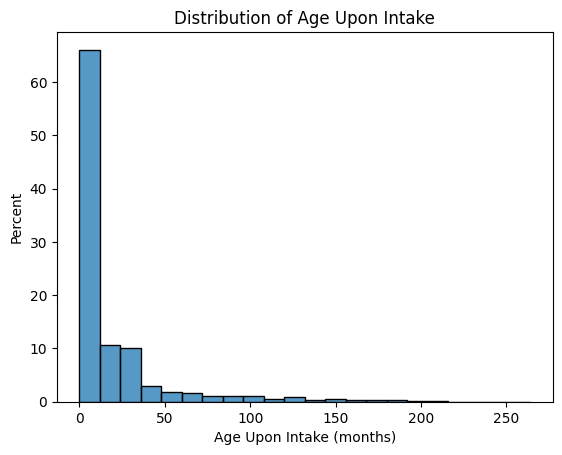

In [12]:
sns.histplot(df, x="age_intake_months", binwidth=12, stat="percent")
plt.title("Distribution of Age Upon Intake")
plt.xlabel("Age Upon Intake (months)")
plt.show()

**Almost 80% of intakes are kittens, 20% are young adults, and less than 10% are mature adults or seniors. Older age groups are increasingly likely to be fixed.**

In [13]:
df["Fixed Upon Intake"] = df["Sex upon Intake"].str.contains("Neutered|Spayed", na=False)
print(f"Percentage of fixed cats upon intake: {df["Fixed Upon Intake"].mean():.2%}.\n")

age_group_order = ["kitten", "young adult", "mature adult", "senior"]
counts = df.groupby(["age_group_intake", "Fixed Upon Intake"])["Animal ID"].count().to_frame("count").reset_index()
counts["percent"] = counts["count"]*1.0/len(df)
pivoted_counts = counts.pivot(columns="Fixed Upon Intake", index="age_group_intake", values="percent").reindex(age_group_order)

Percentage of fixed cats upon intake: 18.61%.



(The hidden code cell generates a visualization of age group upon intake by fixed/intact condition.)

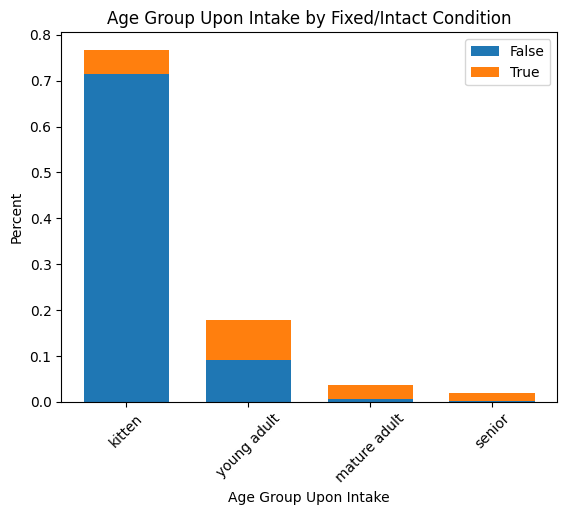

In [14]:
pivoted_counts = dict(pivoted_counts)

fig, ax = plt.subplots()
bottom = np.zeros(4)

for group, count in pivoted_counts.items():
    p = ax.bar(age_group_order, count, 0.7, label=group, bottom=bottom)
    bottom += count

ax.set_title("Age Group Upon Intake by Fixed/Intact Condition")
ax.tick_params(axis="x", labelrotation=45)
ax.set_xlabel("Age Group Upon Intake")
ax.set_ylabel("Percent")
ax.legend(loc="upper right")
plt.show()

### Intake Type
**Nearly 80% of the intakes are strays, and about 20% from owner surrender. Under 20% of intakes are fixed, approximately half of them are strays and half are surrendered, with a small number from public assist.**

(The hidden code cell generates a visualization of intake type by fixed/intact condition.)

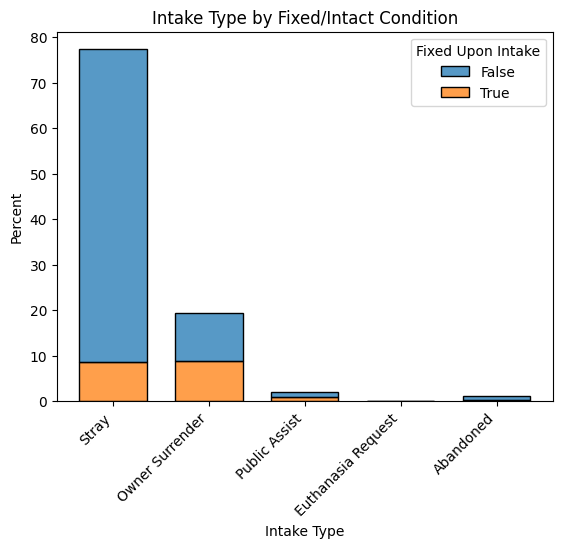

In [15]:
sns.histplot(df, x="Intake Type", hue="Fixed Upon Intake", multiple="stack", stat="percent", legend=True, shrink=0.7)
plt.title("Intake Type by Fixed/Intact Condition")
plt.xticks(rotation=45, ha='right')
plt.show()

## Adoption Rate

### Adoption Rate by Age Group Upon Intake

The number of adoptions are increasingly higher for younger age groups. **In general, younger groups are more likely to be adopted**; however, somewhat surprisingly, mature adults have a higher adoption rate (40%) than young adults (45%). 

As expected, kittens have the highest adoption rate (55%) as they are the youngest and likely the most healthy group. Owners will have more years with them. Mature adults are more likely to be adopted than younger adults, possibly due to sympathy and sentimental value. Seniors have the lowest adoption rate (34%) as they have fewer years and likely require more care.

In [16]:
has_outcomes_df = df[df["has_outcome"]].copy()
stats = has_outcomes_df.groupby("age_group_intake")["is_adopted"]\
    .agg(["count", "mean"])\
    .sort_values(by="count",ascending=False)
is_adopted = has_outcomes_df[has_outcomes_df["is_adopted"]]
stats[len(stats)] = is_adopted.groupby("age_group_intake")["length_of_stay_days"].mean()
stats = stats.reset_index()
stats.columns = ["Age Group Upon Intake", "Adoption Count", "Adoption Rate", "Time to Adoption (Days)"]
stats

,Age Group Upon Intake,Adoption Count,Adoption Rate,Time to Adoption (Days)
0,kitten,52586,0.551097,36.204175
1,young adult,12206,0.401114,42.076593
2,mature adult,2476,0.449919,58.453321
3,senior,1323,0.343159,66.922907


**Younger age groups are adopted at an increasingly faster rate.** 

The average kitten stays 36 days in shelter before adoption, followed by 42 days for young adults, 58 days for mature adults, and 67 days for seniors. Adoptions come sooner for younger and more healthy cats.

(The hidden code cell generates a visualization of adoption rate and average time to adoption by age group upon intake.)

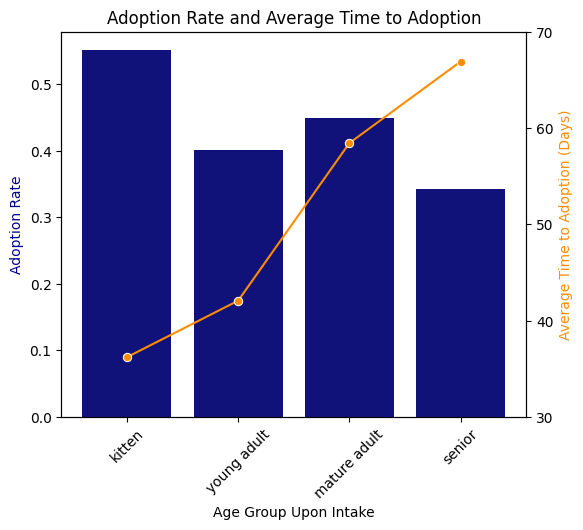

In [17]:
fig, ax1 = plt.subplots(figsize=(6, 5))
sns.barplot(stats, x="Age Group Upon Intake", y="Adoption Rate", color="darkblue", ax=ax1)
ax1.set_xlabel("Age Group Upon Intake")
ax1.set_ylabel("Adoption Rate", color="darkblue")
ax1.tick_params(axis='x', labelrotation=45)
ax2 = ax1.twinx()

sns.lineplot(stats, x="Age Group Upon Intake", y="Time to Adoption (Days)", marker="o", color="darkorange", ax=ax2, sort=False)
ax2.set_ylabel("Average Time to Adoption (Days)", color="darkorange")
ax2.set_ylim(30, 70)
ax2.set_yticks(range(30, 80, 10))

plt.title("Adoption Rate and Average Time to Adoption")
plt.show()

### Adoption Rate by Sex Upon Intake

**Adoption rate is roughly the same across `Sex upon Intake`**, with intact cats having a slightly higher adoption rates than fixed cats.

In [18]:
adoption_rates = has_outcomes_df.groupby("Sex upon Intake")["is_adopted"]\
    .mean()\
    .sort_values(ascending=False)\
    .reset_index()
adoption_rates.columns = ["Sex upon Intake", "Adoption Rate"]

(The hidden code cell generates a visualization of adoption rate by sex upon intake.)

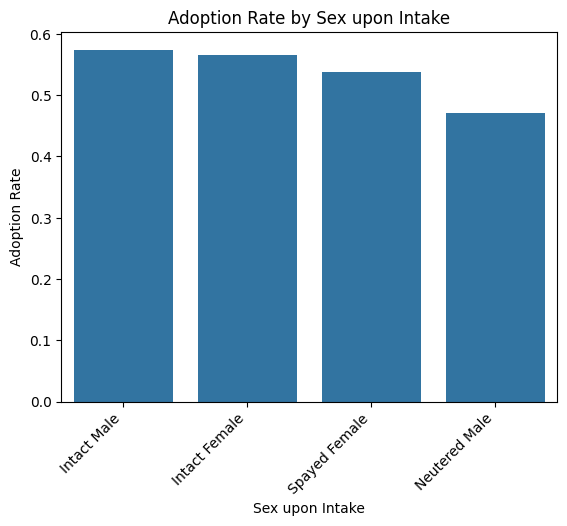

In [19]:
sns.barplot(adoption_rates, x="Sex upon Intake", y="Adoption Rate")
plt.title("Adoption Rate by Sex upon Intake")
plt.xticks(rotation=45, ha='right')
plt.show()

### Adoption Rate by Intake Type

**Different `Intake Type`'s show noticeably different adoption rates.**

Over 70% of surrendered cats are adopted, followed by over 60% of abandoned cats. These cats have been kept as pets and are more likely to become pets again. Under 50% of strays or cats from public assist are adopted. Only around 15% of euthanasia-requested cats are adopted, which makes sense given the nature of their intakes. 

In [20]:
adoption_rates = has_outcomes_df.groupby("Intake Type")["is_adopted"]\
    .mean()\
    .sort_values(ascending=False)\
    .reset_index()
adoption_rates.columns = ["Intake Type", "Adoption Rate"]

(The hidden code cell generates a visualization of adoption rate by intake type.)

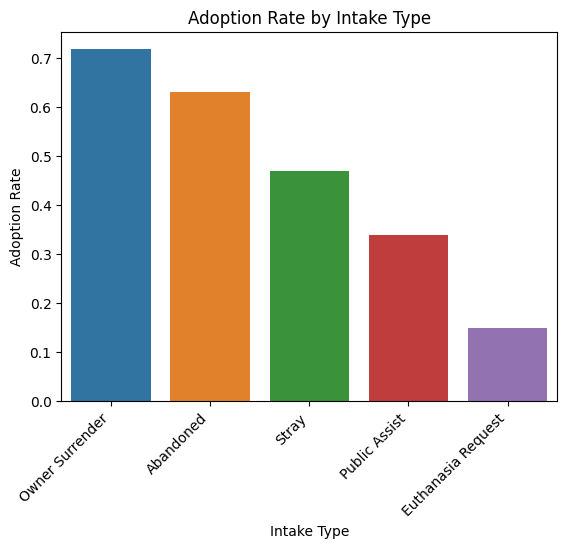

In [21]:
sns.barplot(adoption_rates, x="Intake Type", y="Adoption Rate", hue="Intake Type")
plt.title("Adoption Rate by Intake Type")
plt.xticks(rotation=45, ha='right')
plt.show()

### Adoption Rate by Having Name Upon Intake

**Named cats have a considerably higher adoption rate (almost 70%) than unnamed cats (around 25%)**. A name can evoke positive emotions, such as excitement or affection, from potential pet owners, resulting in a much higher rate of adoption.

In [22]:
has_outcomes_df["Has Name Upon Intake"] = has_outcomes_df["Name_intake"].notna()
adoption_rates = has_outcomes_df.groupby("Has Name Upon Intake")["is_adopted"]\
    .mean()\
    .sort_values(ascending=False)\
    .reset_index()
adoption_rates.columns = ["Has Name Upon Intake", "Adoption Rate"]

(The hidden code cell generates a visualization of adoption rate by having a name upon intake.)

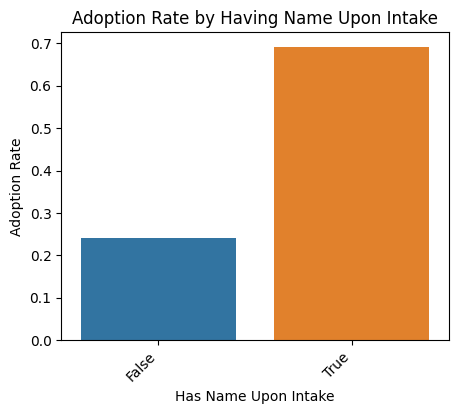

In [23]:
plt.figure(figsize=(5,4))
sns.barplot(adoption_rates, x="Has Name Upon Intake", y="Adoption Rate", hue="Has Name Upon Intake", legend=False)
plt.title("Adoption Rate by Having Name Upon Intake")
plt.xticks(rotation=45, ha='right')
plt.show()

**Do highly adopted intake types, such as "Owner Surrender" and "Abandoned", *also* have higher percentages of named cats?** 

The answer is **No**. The table below shows naming rate alongside adoption rate by intake type. We can see that naming rate and adoption rate do not correlate across intake types. "Euthanasia Request", the least adopted type, is the most named type. 

In [24]:
adoption_rates = has_outcomes_df\
    .groupby(["Intake Type"])[["Has Name Upon Intake", "is_adopted"]]\
    .mean().sort_values(by="Has Name Upon Intake", ascending=False)\
    .reset_index()
adoption_rates.columns = ["Intake Type", "Has Name Upon Intake", "Adoption Rate"]
adoption_rates

,Intake Type,Has Name Upon Intake,Adoption Rate
0,Euthanasia Request,0.900000,0.150000
1,Owner Surrender,0.880768,0.717411
2,Public Assist,0.842689,0.338877
3,Abandoned,0.754032,0.630376
4,Stray,0.535146,0.469651


## Length of Stay (LOS)

LOS varies widely from 0 to 1744 days (almost 5 years), with the standard deviation being 43 days. The average LOS is 23 days and the median is only 7 days, suggesting **the LOS distribution is heavily right skewed**. At least 75% of stays are within one month (31 days).

In [25]:
has_outcomes_df["length_of_stay_days"].describe().to_frame("LOS (days)").T

,count,mean,std,min,25%,50%,75%,max
LOS (days),68591.0,22.962736,42.919208,0.0,2.0,7.0,31.0,1744.0


The distribution of age at intake is heavily right skewed. Each bin represents 30 days; as described above, the vast majority of stays are within one month.

(The hidden code cell generates a visualization of distribution of LOS.)

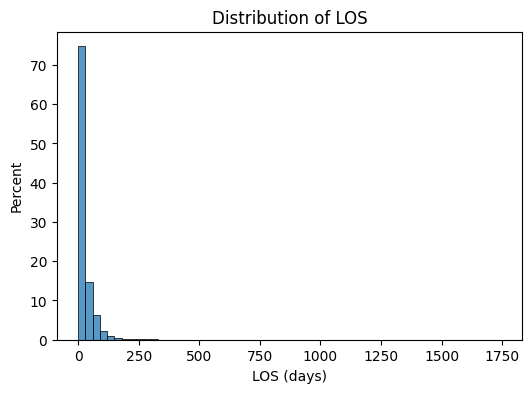

In [26]:
plt.figure(figsize=(6, 4))
sns.histplot(has_outcomes_df, x="length_of_stay_days", binwidth=30, stat="percent")
plt.title("Distribution of LOS")
plt.xlabel("LOS (days)")
plt.show()

### LOS by Age Group Upon Intake

**Kittens and young adults have shorter stays on average (under 25 days) than mature adults and seniors (over 30 days).**

In [27]:
los_stats = has_outcomes_df.groupby("age_group_intake")["length_of_stay_days"]\
    .agg(["count", "mean"])\
    .sort_values(by="count", ascending=False)

(The hidden code cell generates a visualization of average LOS by age group upon intake.)

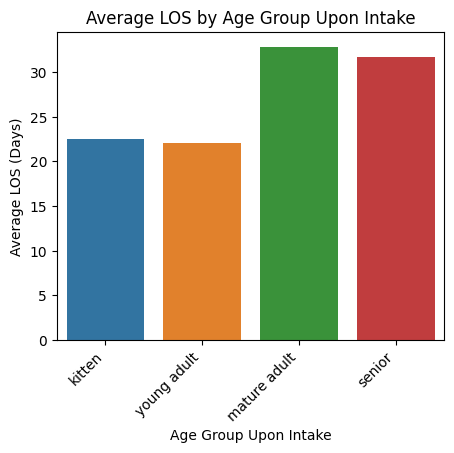

In [28]:
plt.figure(figsize=(5,4))
sns.barplot(los_stats, x="age_group_intake", y="mean", hue="age_group_intake", legend=False)
plt.title("Average LOS by Age Group Upon Intake")
plt.xlabel("Age Group Upon Intake")
plt.ylabel("Average LOS (Days)")
plt.xticks(rotation=45, ha='right')
plt.show()

**Euthanasia-requested cats have shorter stays (about 12 days) on average than other intake types (over 20 days)**. This makes sense as the outcome of euthanasia requests is pre-determined and subsequently fulfilled. Other intake types need more time to reach an outcome.

In [29]:
los_stats = has_outcomes_df.groupby("Intake Type")["length_of_stay_days"]\
    .mean()\
    .sort_values()\
    .reset_index()

(The hidden code cell generates a visualization of average LOS by intake type.)

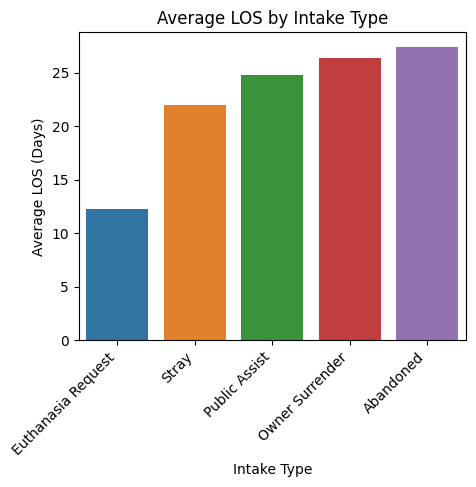

In [30]:
plt.figure(figsize=(5,4))
sns.barplot(los_stats, x="Intake Type", y="length_of_stay_days", hue="Intake Type", legend=False)
plt.title("Average LOS by Intake Type")
plt.xlabel("Intake Type")
plt.ylabel("Average LOS (Days)")
plt.xticks(rotation=45, ha='right')
plt.show()

### Long Stays

Approximately 25% of stays last longer than 30 days: 15% of stays are between 1-2 months, 6% are between 2-3 months, and 4% are over 3 months.

In [31]:
long_stays = pd.DataFrame({"Time Period": ["Within 30 Days", "31 to 60 Days", "61 to 90 Days", "Over 91 Days"],
                           "Count": [(has_outcomes_df["length_of_stay_days"]<=30).mean()*100, 
                                     (has_outcomes_df["length_of_stay_days"].between(31, 60)).mean()*100,
                                     (has_outcomes_df["length_of_stay_days"].between(61, 90)).mean()*100, 
                                     (has_outcomes_df["length_of_stay_days"]>91).mean()*100]})

(The hidden code cell generates a visualization of proportion of LOS.)

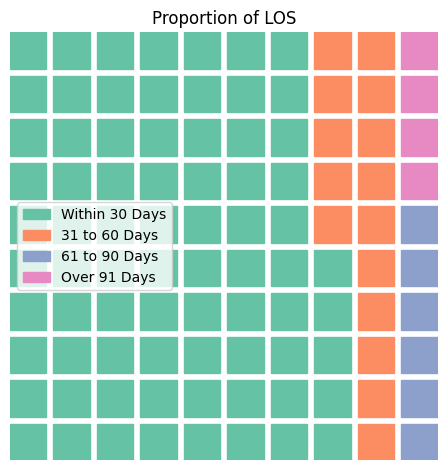

In [32]:
plt.figure(
    FigureClass = Waffle,
    rows = 10,
    values = long_stays["Count"],
    labels = list(long_stays["Time Period"]),
    legend={'loc': 'center left', 'fontsize': 10}
)
plt.title("Proportion of LOS")
plt.show()

## Seasonality

**Intakes follow a seasonal trend: surging in spring and summer, and plunging in fall in winter. Average LOS also follows a similar seasonal trend to intakes**. 

Spring and summer are peak kitten seasons according to [pethealthnetwork.com](https://www.pethealthnetwork.com/cat-health/cat-checkups-preventive-care/what-kitten-season#:~:text=In%20the%20Northern%20Hemisphere%2C%20the%20feline%20breeding,state%20of%20dormancy%20referred%20to%20as%20%E2%80%9Canestrus.%E2%80%9D); more kittens born mean more intakes at the center. The sudden rise in intakes may lead to higher supply for adoptions and fewer resources regarding vet care, marketing and administration allocated to each cat, resulting in longer LOS.

The seasonal trend still applies in 2020; however, intakes decreased and average LOS increased noticeably in that year. The driving factor was likely social distancing and limited resources during COVID, straining operations and leading to reduced intakes and prolonged LOS. Intakes and LOS returned to their pre-COVID level in late 2021 or early 2022. The seasonal trend is maintained throughout the entirety of the data.

In [33]:
monthly_intake_count = df.groupby("month_year_intake")["Animal ID"].count()
monthly_average_los = df.groupby("month_year_intake")["length_of_stay_days"].mean()

(The hidden code cell generates a visualization of monthly intake and average LOS.)

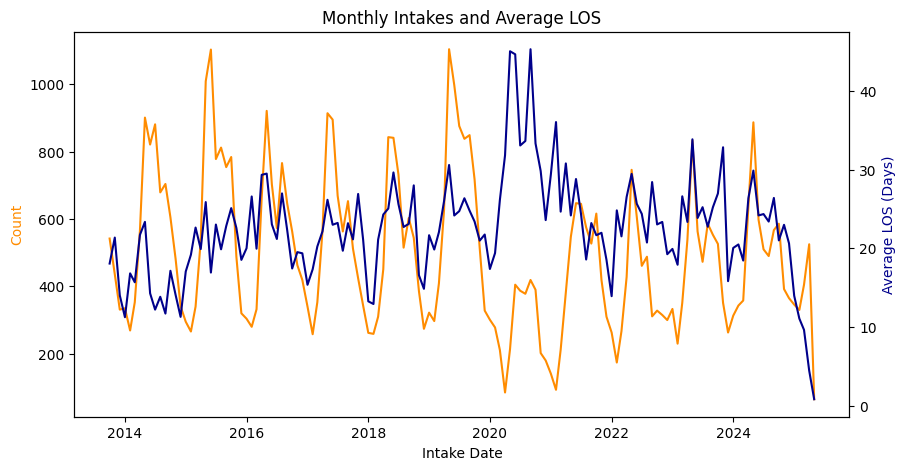

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(monthly_intake_count, color="darkorange", ax=ax1)
ax1.set_xlabel("Intake Date")
ax1.set_ylabel("Count", color="darkorange")

ax2 = ax1.twinx()
sns.lineplot(monthly_average_los, color="darkblue", ax=ax2, sort=False)
ax2.set_ylabel("Average LOS (Days)", color="darkblue")

plt.title("Monthly Intakes and Average LOS")
plt.show()

**Adoption rate fluctuates throughout the year, with peak adoption in May and November-January.** May is within the kitten season and also when intakes peak (increased supply), and November to January is the long holiday season (increased free time and demand for adoption). 

In [35]:
has_outcomes_df["month_intake"] = has_outcomes_df["datetime_intake"].dt.month
monthly_stats = has_outcomes_df.groupby("month_intake")[["length_of_stay_days", "is_adopted"]].mean()

(The hidden code cell generates a visualization of average LOS and adoption rate by month.)

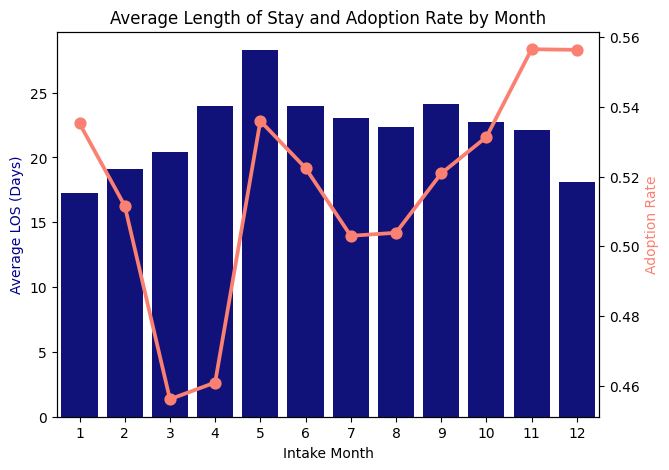

In [36]:
fig, ax1 = plt.subplots(figsize=(7, 5))
sns.barplot(x=monthly_stats.index, y=monthly_stats["length_of_stay_days"], color="darkblue", ax=ax1)
ax1.set_xlabel("Intake Month")
ax1.set_ylabel("Average LOS (Days)", color="darkblue")

ax2 = ax1.twinx()
sns.pointplot(monthly_stats["is_adopted"], color="salmon", marker="o", ax=ax2)
ax2.set_ylabel("Adoption Rate", color="salmon")

plt.title("Average Length of Stay and Adoption Rate by Month")
plt.show()

## Outcome-related Data (Descriptive Only)

**NOTE: Outcome variables are used for descriptive analysis only, not as model inputs.**

Over half of the intakes result in adoptions and under 40% in transfers. 4% of intakes are returned to owner and another 4% euthanized. 

In [37]:
counts = has_outcomes_df["Outcome Type"].value_counts().sort_values().reset_index()
small_categories = list(counts["Outcome Type"].head(5))
has_outcomes_df["outcome_temp"] = np.where(
    has_outcomes_df["Outcome Type"].isin(small_categories), "Other", has_outcomes_df["Outcome Type"]
)
recounts = has_outcomes_df["outcome_temp"].value_counts().sort_values().reset_index()

(The hidden code cell generates a visualization of distribution of outcome type.)

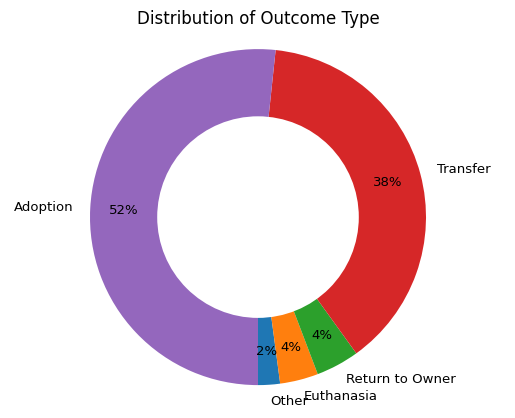

In [38]:
fig, ax = plt.subplots()
ax.pie(recounts["count"], 
       labels=recounts["outcome_temp"],
       autopct='%1.0f%%', 
       startangle=-90, 
       pctdistance=0.8, 
       labeldistance=1.1, 
       textprops={'fontsize': 9.5})
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal') 
plt.title("Distribution of Outcome Type")
plt.show()

The rate of adoption is similar to the rate of transfer across all age groups upon intake.

In [39]:
outcome_order = ["Adoption", "Transfer", "Return to Owner", "Euthanasia", "Other"]
counts = has_outcomes_df.groupby(["age_group_intake", "outcome_temp"])["Animal ID"].count().to_frame("count").reset_index()
counts["percent"] = counts["count"]*1.0/len(df)
pivoted_counts = counts.pivot(columns="outcome_temp", index="age_group_intake", values="percent").reindex(age_group_order)
pivoted_counts = pivoted_counts[outcome_order]

(The hidden code cell generates a visualization of outcome type by age group upon intake.)

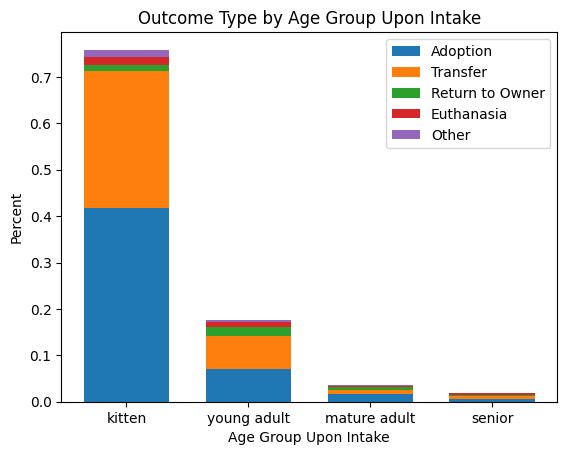

In [40]:
pivoted_counts = dict(pivoted_counts)

fig, ax = plt.subplots()
bottom = np.zeros(4)

for group, count in pivoted_counts.items():
    p = ax.bar(age_group_order, count, 0.7, label=group, bottom=bottom)
    bottom += count

ax.set_title("Outcome Type by Age Group Upon Intake")
ax.legend(loc="upper right")
ax.set_xlabel("Age Group Upon Intake")
ax.set_ylabel("Percent")
plt.show()